<div>
<img src="https://www.nebrija.com/images/logos/logotipo-universidad-nebrija.jpg" width="200">
</div>

**ALGORITMOS** -
Prof: Carmen Pellicer Lostao

# Qiskit Runtime

Hay dos métodos para acceder a los sistemas IBM Quantum:


*   En primer lugar, el paquete `qiskit-ibm-provider` proporciona la interfaz `backend.run()`, que permite el acceso directo a los sistemas IBM Quantum sin necesidad de procesamiento previo o posterior. Este nivel de acceso es adecuado para aquellos usuarios que desean un control preciso sobre la ejecución del circuito y el procesamiento de resultados (p. e. circuitos dinámicos).

*   En segundo lugar, utilizando el paquete `Qiskit Runtime` que está diseñado para agilizar la construcción de algoritmos y aplicaciones al eliminar la necesidad de que los usuarios comprendan los detalles técnicos del hardware y del software de bajo nivel. **Las sesiones dentro de Qiskit Runtime permiten a los usuarios ejecutar circuitos de algoritmos iterativos uno tras otro, o colecciones de circuitos por lotes sin tener que volver a poner en cola cada trabajo.**

En este notebook vemos cómo usar el servicio Qiskit Runtime y crear programas sobre la construcción de primitivas. La documentacion para usar este servicio puedes encontrarla en [Runtime docs](https://docs.quantum.ibm.com/run)

## Set-up del entorno

Comenzaremos con `Qiskit Runtime`. Qiskit Runtime ya está instalado y configurado en la instancia de IBM Quantum Lab del IBM.

Si se ejecuta en otros entornos, es posible que se requiera instalar los paquetes Qiskit Runtime, lo que se puede hacer usando: `pip install qiskit-ibm-runtime`. 

El bloque siguiente de codigo guarda las credenciales de la cuenta Runtime de IBMQ en un entorno actual. El argumento de la palabra clave `channel` permite que Runtime sepa si se está utilizando IBM Quantum regular (`channel='ibm_quantum'`) o IBM Cloud (`channel='ibm_cloud'`). Usaremos el canal `ibm_quantum` para todas nuestras ejecuciones. Esta celda se puede ejecutar solo una vez y las credenciales se guardan para este entorno. Y para el argumento de la palabra clave `token`, es necesario codificar el valor de tu token API se encuentra en el enlace de la cuenta de IBMQ: **[quantum-computing.ibm.com/account](https://quantum-computing.ibm.com/account)**.

In [15]:
#!pip install qiskit-ibm-runtime

In [16]:
# Save the Runtime account credentials if you have not done so already
# If you need to overwrite the account info, please add `overwrite=True`
QiskitRuntimeService.save_account(channel='ibm_quantum', token='807454d47ee36239856f1751489e9a6c0df8e433a4c335f8cd9d4d7fc697fce7f1d6fbeec86553b2cd8d3d61ae73114b9c704a520699b9ba5b0eb3afd2c1dab1', overwrite=True)

En el entorno de IBM Quantum Lab, simplemente debemos de llamar a `QiskitRuntimeService` con el canal adecuado para las ejecuciones posteriores.

Definimos la instancia `QiskitRuntimeService` para ejecutar un circuito programa o circuito cuantico, usamos este servicio para llamar a las dos primitivas actualmente disponibles según sea necesario; `Sampler` y `Estimator` y ejecutarlo en Qiskit Runtime.

In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator

In [18]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")

Como en el modelo de ejecucion con el paquete `ibm-qiskit-provider`, aqui tambien podemos consultar el backend mas liberado si vamos a ejecutar en HW real

In [19]:
backend = service.least_busy(operational=True, simulator=False)   #
backend.name

'ibm_osaka'

Finalmente importamos las librerias de trabajo para el notebook

In [20]:
import time
import numpy as np
import math
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector

## Introduccion a las primitivas de Qiskit runtime

Desde 2022 IBM ha introducido un nuevo modelo de programación que mejora la experiencia de programacion, puesto que permite una ejecucion mejorada de los circuitos cuánticos. El __servicio Qiskit Runtime__ maximiza un _flujo de trabajo cuántico_ dado, que es predominantemente una QPU en la nube y ofrece un modelo de programación computacional que se ajusta a un servicio creado para optimizar las cargas de trabajo con una ejecución eficiente a escala.

<img src="https://cloud.ibm.com/docs-content/v1/content/fe08b8e3a114015612ab3ed112afa281d6ce896a/quantum-computing/images/Qiskit_Runtime_architecture.png" style="width: 1000px" />

Qiskit Runtime es una nueva arquitectura que agiliza los cálculos que requieren muchas iteraciones. Estos experimentos se ejecutarán significativamente más rápido dentro de su proceso híbrido cuántico/clásico mejorado.

Es un nuevo paradigma de programación que permite interactuar con el servicio de IBM Qiskit Runtime y aprovechar el poderoso servicio y el framework en el cual está construido.

Se trata de un servicio que encapsula en las primitivas del lenguaje una serie de funcionalidades que nos facilitan el desarrollo en un nivel superior mientras confiamos en el compilador para tener un flujo de trabajo optimizado, puedes esperar que Runtime aborde estas áreas más comunes:

- **Eficiencia** : Rutinas altamente optimizadas y opciones para cargas de trabajo iterativas diseñadas para backends cuánticos
- **Latencia** : Planificación, priorización de trabajos y almacenamiento en caché compartido utilizando el framework de sesiones para una menor latencia y tiempos de resultado más rápidos.
- **Consistencia** : Modelo de programación consistente para desarrollar rutinas complejas en todo el servicio con adiciones más recientes para complementar el modelo primitivo existente
- **Personalización** : Manejo de rutinas iterativas con circuitos personalizados con base en su contexto y parámetros de trabajo
- **Mitigación y Supresión de Errores** : Avances en la investigación sobre mitigación y supresión de errores a través de interfaces abstractas simples para una mayor calidad de la información.

## Primitivas de Qiskit Runtime: Introducción a Sampler y Estimator


El servicio [Qiskit Runtime](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/runtime_service) tiene dos primitivas básicas: el __Sampler__ y el __Estimator__ . Las librerias que describen estas primitivas pueden verse en [Qiskit Primitives](https://docs.quantum.ibm.com/api/qiskit/primitives)

Con respecto al punto de interés de información clave aquí, la capacidad central de las computadoras cuánticas que las distingue de las computadoras clásicas es su capacidad para generar distribuciones de probabilidad no clásicas en sus salidas. La naturaleza inherente de los resultados computacionales altamente probabilísticos que se obtienen requiere que tengamos varias ejecuciones del mismo circuito para generar información utilizable en forma de distribuciones de probabilidad. Las operaciones nativas que podemos hacer con las distribuciones de probabilidad son muestrearlas o estimar cantidades a partir de ellas.

Con base en estos dos puntos de información de interés aquí, que son: **a) Distribuciones de probabilidad de muestreo** y **b) Estimación de un valor**, llegamos a nuestras dos primitivas con nombre apropiado: **El Sampler** y **El Estimator**

*  El **Sampler** esencialmente hace lo que dice su nombre. Al muestrear su salida, estima la distribución de cuasi-probabilidad completa de un circuito cuántico dado. Este es un programa que toma los circuitos de un usuario como entrada y genera una lectura de cuasi-probabilidades con errores mitigados. Esto brinda a los usuarios una forma de evaluar mejor los resultados de las iteraciones mediante la mitigación de errores y les permite evaluar de manera más eficiente la posibilidad de múltiples puntos de datos relevantes en el contexto de la interferencia destructiva.

*   El **Estimator** básicamente calcula e interpreta los valores esperados de los operadores de interés. Esta es una interfaz de programa que toma circuitos y observables y permite a los usuarios agrupar selectivamente entre circuitos y observables para su ejecución. El estimador permite evaluar de manera eficiente los valores esperados y las variaciones para un parámetro de entrada dado en los circuitos parametricos. En algoritmos de optimizacion hibridos permite calcular los valores esperados y encontrar una solución final a un problema dado que no necesita examinar la distribución completa de los conteos, sino solamente unos valores esperados.




## SAMPLER

Con la ejecucion interactiva que permite `Runtime` podemos ejecutar varios circuitos, vamos a probarlo con el algoritmo de Deutsch-Jozsa

#### EJERCICIO

Crea una funcion que genere el circuito del algoritmo Deutsch-Jozsa incluyendo la parte final de las medidas

In [21]:
def dj_oracle(n):
    #La funcion crea un objeto de QuantumCircuit y lo devuelve
    #El circuito del oraculo tiene n qubit de entrada y uno de salida -> en total n+1 qubits

    oracle_qc = QuantumCircuit(n+1)

    #sorteamos el tipo de funcion del oraculo 0=constante y 1=balanceada
    cnst = np.random.randint(2)

    if cnst==0:
        #Caso de un oraculo constante
        ran = np.random.randint(2)
        if ran==1:
            print("Funcion constante de valor 1")
            oracle_qc.x(n)
        else:
            print("Funcion constante de valor 0")
    else:
        #Caso de un oraculo balanceado
        print("Funcion balanceada")
        for ind in range(n):
            oracle_qc.cx(ind,n)

    oracle_qc.name = 'DJ-Oracle' 
    return oracle_qc

In [22]:
def dj_alg(n):
    #La funcion crea un objeto de QuantumCircuit y lo devuelve
    #El circuito del oraculo tiene n qubit de entrada y uno de salida -> en total n+1 qubits

    circuit = QuantumCircuit(n+1,n)

    #ponemos los qubits de entrada en superposicion
    circuit.h(range(n))
    circuit.barrier()
    #rand Oracle
    #sorteamos el tipo de funcion del oraculo 0=constante y 1=balanceada
    circuit = circuit.compose(dj_oracle(n))
    circuit.barrier()
    #Caso de un oraculo constante


    #Caso de un oraculo balanceado

    #puertas h al final
    circuit.h(range(n))
    circuit.barrier()


    #ponemos las puertas de medida
    circuit.measure(range(n),range(n))

    circuit.name = 'DJ-Alg-circuit' #to show in the display circuit
    return circuit

A partir de esta funcion crea varios circuitos y muestralos:

Funcion balanceada
Funcion constante de valor 0


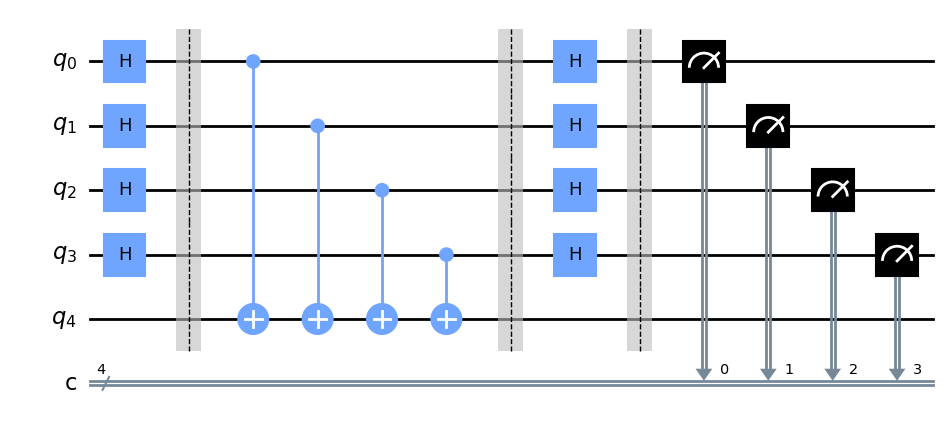

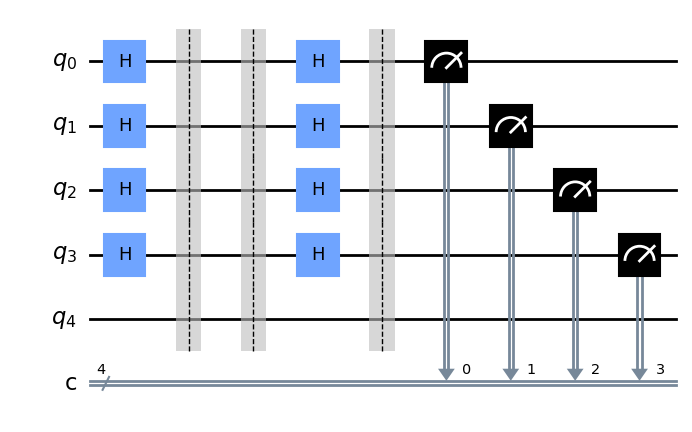

In [23]:
qc1=dj_alg(4)
qc2=dj_alg(4)

display(qc1.draw("mpl"))
display(qc2.draw("mpl"))

### EJECUCION CON UNA SESION

En la documentacion tenemos algunos ejemplos de como utilizar la clase Smapler [ejemplos](https://docs.quantum.ibm.com/run/primitives-examples#use-sessions-and-advanced-options-1) y la prpopia definicion de la clase [`Sampler`] (https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Sampler)

In [24]:
#Definimos un backend de simulacion
backend ="ibmq_qasm_simulator"
print(backend)

ibmq_qasm_simulator


In [25]:
options = Options(simulator={"seed_simulator": 42}, resilience_level=0) # Some options values for the simulator

In [26]:
with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(circuits=[qc1,qc2])

Después de ejecutar el `Sampler`, devuelve un objeto `RuntimeJob` y podemos extraer los resultados de este objeto usando el método `result` para verificar los datos devueltos. 

Luego podemos seleccionar nuestros datos individuales de interés a partir de este resultado devuelto.

La informacion del resultado de las ejecuciones podemos verla tambien en las librerias de [SamplerResult](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.SamplerResult).

#### EJERCICIO

Analiza la estructura de la clase `SamplerResult` y muestra por pantalla los resultados obtenidos para cada ejecucion, en un formato que se vean los estados y las distribuciones de probabilidad obtenidas para cada ejecucion

In [ ]:
resultado = job.result()
print(job.result())

for i in resultado.quasi_dists:
    print(i.items())

Vemos que en la distribucion de resultados, se muestran los estados codificados como numeros enteros. 

Analiza el el método `binary_probabilities`de la clase `QuasiDistribution`.[Consultar la info de esta clase](https://docs.quantum.ibm.com/api/qiskit/qiskit.result.QuasiDistribution) para mostrar la visualizacion de las distribuciones con los strings de los resultados en fomato birario en lugar de numeros enteros

In [ ]:
for i in resultado.quasi_dists:
    print(i.binary_probabilities())

{'0000': 1.0}
{'1111': 0.50725, '0000': 0.49275}


### EJECUCION CON UN UNICO JOB

Podemos ejecutar las primitivas de Runtime, abriendo una sesion, como lo hemos hecho hasta ahora. Una sesión es una característica de Qiskit Runtime que le permite ejecutar de manera eficiente cargas de trabajo iterativas de múltiples trabajos en computadoras cuánticas. El uso de sesiones ayuda a evitar retrasos causados ​​por poner en cola cada trabajo por separado, lo que puede ser particularmente útil para tareas iterativas que requieren comunicación frecuente entre recursos clásicos y cuánticos.

Sin embargo podemos utilizarlas tambien directamente sin sesiones y ejecutar multiples circuitos en un solo job.

In [ ]:
sampler = Sampler(backend=backend)
job = sampler.run(circuits=[qc1,qc2])

result = job.result()
print(result)
print(result.quasi_dists)

SamplerResult(quasi_dists=[{0: 1.0}, {0: 0.4845, 15: 0.5155}], metadata=[{'shots': 4000, 'circuit_metadata': {}}, {'shots': 4000, 'circuit_metadata': {}}])
[{0: 1.0}, {0: 0.4845, 15: 0.5155}]


In [ ]:
for i in result.quasi_dists:
    print(i.binary_probabilities())

{'0000': 1.0}
{'0000': 0.4845, '1111': 0.5155}


#### EJERCICIO

Muestra los resultados obtenidos del muestreo con las quasiprobabilidades de cada estado medido expresados como valores enteros y strings binarias

## CIRCUITOS PARAMETRICOS con el SAMPLER

Uno de los principales beneficios de las primitivas es la simplificación de la ejecuciones multiples cuando tenemos circuitos paramétricos donde el valor del parametros debe de evaluarse multiples veces.

#### EJERCICIO

Crea el siguiente circuito parametrico que tenga medidas solo en el qubit $q_0$

<img src="https://cdn.discordapp.com/attachments/1012968177258483802/1200434492486209649/image.png" style="width: 500px"/>

In [30]:
#Definimos el parametro
theta = Parameter('theta')

#y los 50 valores que va a tomar
phases = np.linspace(0, 2*np.pi, 50) # Specify the range of parameters to look within 0 to 2pi with 50 different phases
individual_phases = [[ph] for ph in phases] # Phases need to be expressed as list of lists in order to work

print('total numero de parametros',len(individual_phases))
print(individual_phases)

total numero de parametros 50
[[0.0], [0.1282282715750936], [0.2564565431501872], [0.38468481472528077], [0.5129130863003744], [0.6411413578754679], [0.7693696294505615], [0.8975979010256552], [1.0258261726007487], [1.1540544441758422], [1.2822827157509358], [1.4105109873260295], [1.538739258901123], [1.6669675304762166], [1.7951958020513104], [1.9234240736264039], [2.0516523452014974], [2.179880616776591], [2.3081088883516845], [2.436337159926778], [2.5645654315018716], [2.6927937030769655], [2.821021974652059], [2.9492502462271526], [3.077478517802246], [3.2057067893773397], [3.333935060952433], [3.4621633325275267], [3.5903916041026207], [3.7186198756777142], [3.8468481472528078], [3.9750764188279013], [4.103304690402995], [4.231532961978089], [4.359761233553182], [4.487989505128276], [4.616217776703369], [4.744446048278463], [4.872674319853556], [5.00090259142865], [5.129130863003743], [5.257359134578837], [5.385587406153931], [5.513815677729024], [5.642043949304118], [5.7702722208

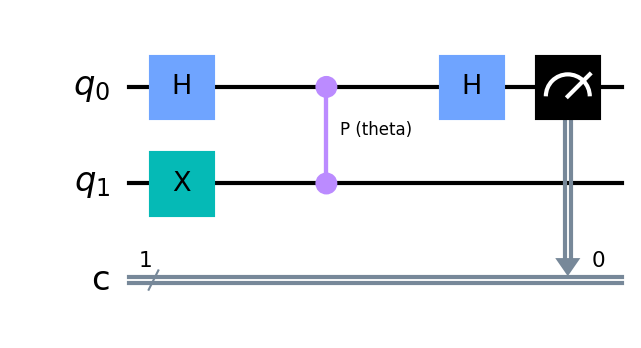

In [31]:
#Creamos el circuito
qc = QuantumCircuit(2,1)
qc.h(0)
qc.x(1)
qc.cp(theta,0,1)
qc.h(0)
qc.measure(0,0)

qc.draw("mpl",scale=1.5)

Crea una visualizacion de los estados que genera este circuito para los diferentes valores de los parametros que toma `theta` en el circuito. Por ejemplo para los 5 o 10 primeros circuitos.

radianes 0.0 grados 0.0
radianes 1.2822827157509358 grados 73.46938775510203
radianes 2.5645654315018716 grados 146.93877551020407
radianes 3.8468481472528078 grados 220.40816326530611
radianes 5.129130863003743 grados 293.87755102040813


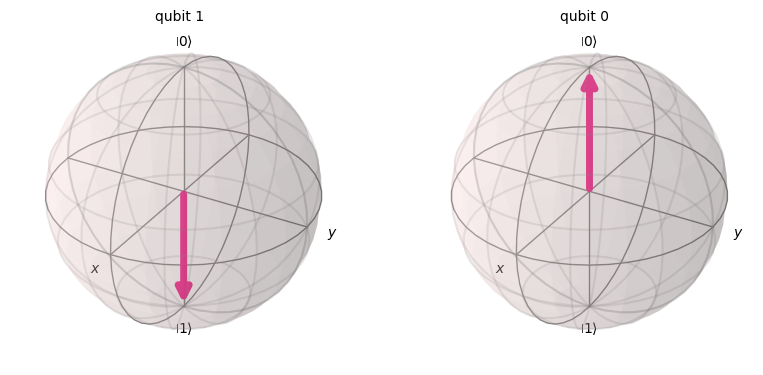

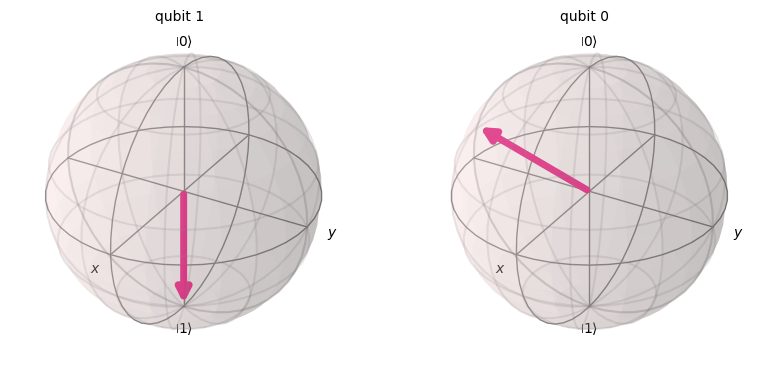

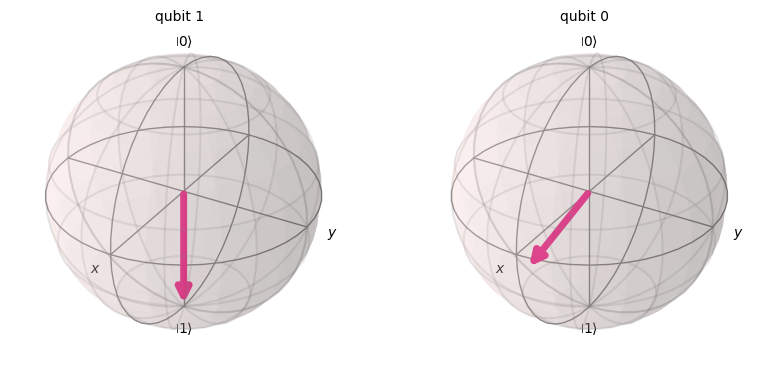

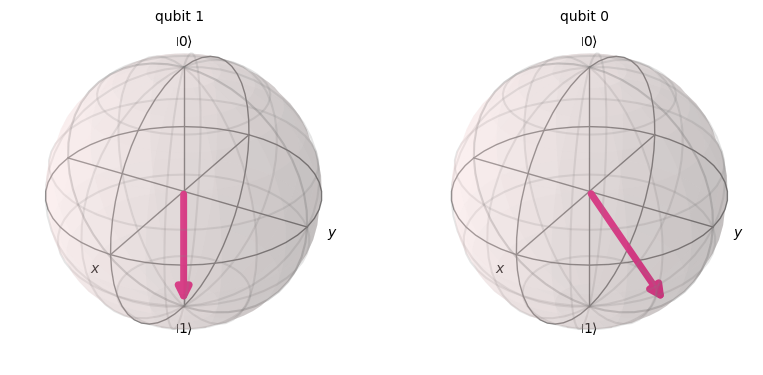

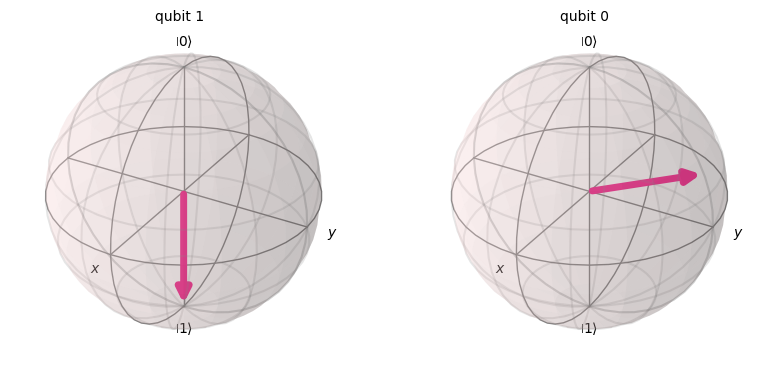

In [32]:
# help understanding of how its phase is moving
states = []

simulator = Aer.get_backend('aer_simulator')

for i in range(0, 50, 10):  #representamos solo los 5 primeros
    temp = QuantumCircuit(2,1)#crea un circuito temporal para cada valor de fase
    temp.h(0)
    temp.x(1)
    temp.cp(individual_phases[i][0],0,1)
    temp.h(0)
    #display(temp.draw("mpl"))
    
    #descomentar la siguiente para ver el giro en torno al eje z que hace la puerta control-p en el qubit_0 a partir del estado |+>
    print('radianes',individual_phases[i][0], 'grados', math.degrees(individual_phases[i][0]))

    state = Statevector(temp)
    states.append(state)
    
#vualiza los estados con plot_bloch_multivector
for i in range(5):
    display(plot_bloch_multivector(states[i],reverse_bits=True))


Utilizamos el `Sampler`, y necesitaremos vincular parámetros a un circuito parametrizado. 

Agregamos `individual_phases` al circuito `qc` que hicimos anteriormente usando Sampler. Para ello podemos ver en detalle la descripcion del metodo `run`de la clase [Sampler](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Sampler) .

Cuando creemos un objeto `Sampler`, agreguamos el parámetro `options` con una semilla.

El método de ejecución del `Sampler` tiene que tener los siguientes parámetros:

>`circuitos`: Uno o más objetos de circuito.

>`parameter_values`: parámetros que se vincularán al circuito.

El tipo de respuesta debe ser **[SamplerResult](https://qiskit.org/documentation/stubs/qiskit.primitives.SamplerResult.html)**.

In [33]:
backend ="ibmq_qasm_simulator"
print(backend)
options = Options(simulator={"seed_simulator": 42}, resilience_level=0) # Do not change values in simulator

ibmq_qasm_simulator


In [14]:
with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(circuits=[qc]*len(phases), parameter_values=individual_phases)
    result = job.result()

NameError: name 'qc' is not defined

In [ ]:
print(result)

La celda de código anterior toma el circuito parametrizado y lo ejecuta en un backend utilizando el servicio Runtime. Esta rutina vincula cada parámetro al circuito definido y ejecuta todos los circuitos resultantes para darnos el resultado colectivo.

Representemos ahora el resultado que obtuvimos, para ello representaremos las cuasi distribuciones para la probabilidad de estar en el estado 1 para cada uno de estos circuitos. Cada circuito tendrá diferentes valores theta como parámetros de fase.

El metodo que nos da la quasi probabilidad de medir un estado en el metodo `get`de la clase `QuasiDistribution`.[Consultar la info de esta clase](https://docs.quantum.ibm.com/api/qiskit/qiskit.result.QuasiDistribution) 

In [28]:
#resultado teorico
phases = np.linspace(0, 2*np.pi, 50)
valor_teorico=np.sin(phases/2,)**2

# La probabilidad de estar en el estado 1 el qubit q_0 para cada ejecucion del Sampler
prob_values = [dist.get(1,0) for dist in result.quasi_dists]  #get(1) nos devuelve la quasi-probabilidad de medir 1 y el cero es el valor por defecto, por si no hay probabilidad en el estado 1 nos devolverá 0

plt.plot(phases, prob_values, 'o', label='simulator')
plt.plot(phases, valor_teorico , label='theory')
plt.xlabel('Phase')
plt.ylabel('Probability')
plt.legend();

NameError: name 'result' is not defined

La línea amarilla es el resultado teóricamente esperado, mientras que los puntos azules son los valores que obtenemos al ejecutarlo en el backend. Como puede ver, está mayormente alineado con la teoría y hay ligeras desviaciones en la curva en la distribución resultante debido a la ligera aleatoriedad inherente del `ibmq_qasm_simulator`.

## ESTIMATOR

Hasta ahora hemos analizado las distribuciones de cuasi probabilidad, pero también podemos analizarlas en términos de evaluación de los valores esperados, con la primitiva `Estimator`.

El Estimator devuelve los valores esperados calculados e interpretados de los operadores cuánticos. 

**IMPORTANTE**: El Estimator requiere que el circuito este 'sin mediciones'. El motivo es que, al ejecutar algoritmos como VQE, el Estimator trabajará con hamiltonianos, por lo que no podemos tener mediciones.

In [34]:
#para quitar las mediciones de un circuito, si se necesita en algun caso
qc_no_meas = qc.remove_final_measurements(inplace=False)

Para calcular su valor esperado, necesitamos establecer un observable para el circuito. En este caso, usaremos el observable 'ZZ', que significa que medimos en el eje Z para todos los qubits en el circuito. 

Para crear los hamiltonianos que usaremos de medida utilizaremos el operador [SparsePauliOp](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html)

**IMPORTANTE**: La longitud del observable es la misma que la cantidad de qubits en el circuito.

In [35]:
ZZ = SparsePauliOp.from_list([("ZZ", 1)])

El valor esperado se calcula mediante la siguiente ecuación.

$$
\langle ZZ\rangle =\langle \psi | ZZ | \psi\rangle=\langle \psi|(|0\rangle\langle 0| -|1\rangle\langle 1|)\otimes(|0\rangle\langle 0| - |1\rangle\langle 1|) |\psi\rangle =|\langle 00|\psi\rangle|^2 - |\langle 01 | \psi\rangle|^2 - |\langle 10 | \psi\rangle|^2 + |\langle 11|\psi\rangle|^2
$$

In [39]:
options = Options(simulator={"seed_simulator": 42}, resilience_level=0)

backend ="ibmq_qasm_simulator"

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuits=[qc_no_meas]*len(phases), parameter_values=individual_phases, observables=[ZZ]*len(phases))

Después de ejecutar el `Estimator` con el comando [`run`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Estimator). debemos de pasar una losta de circuitos, de parametros y de observables para medir los circuito.

Este método devuelve un objeto `RuntimeJob` y podemos extraer los resultados de este objeto usando el método `result` para verificar los datos devueltos. 

Luego podemos seleccionar nuestros datos individuales de interés a partir de este resultado devuelto.

La informacion del resultado de las ejecuciones podemos verla tambien en las librerias de [EstimatorResult](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.EstimatorResult).

In [ ]:
print(job.result())

La celda de código anterior toma el circuito parametrizado y lo ejecuta en un backend utilizando el servicio Runtime. Esta rutina vincula cada parámetro al circuito definido y ejecuta todos los circuitos resultantes para darnos el resultado colectivo. Los valores estimados se miden respecto del observable que hemos definido y se recogen en el parametro `values` de la clase `EstimatorResult`

Representemos ahora el resultado que obtuvimos, para ello representaremos los valores estimados medidos para cada circuito con diferente valor del parametro `theta`.

In [ ]:
param_results = job.result()
exp_values = param_results.values

plt.plot(phases, exp_values, 'o', label='real')
plt.plot(phases, 2*np.sin(phases/2,)**2-1, label='theory')
plt.xlabel('Phase')
plt.ylabel('Expectation')
plt.legend();

## CIRCUITOS PARAMETRICOS con el ESTIMATOR

Vamos ahora a contruir circuitos parametricos con las librerías que `Qiskit` tiene para ello.

Un tipo de circuito parametrico muy usado es el de **[RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html)**. Vease el código de ejemplo para construilos. 

Este `ansatz` es el circuito con 3 qubits y `reps` es 2. En este caso, el número total de parámetros es $3 \times (2+1) = 9$.


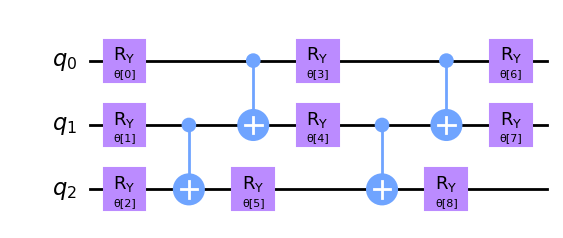

In [44]:
ansatz = RealAmplitudes(3, reps=2)  # create the circuit on 3 qubits

ansatz.decompose().draw("mpl")

#### EJERCICIO

Crea una rutina Estimator para calcular los valores esperados de los Hamiltonianos dados con respecto a ciertos observables. El resultado final debe ser un objeto de la clase **[EstimatorResult](https://qiskit.org/documentation/stubs/qiskit.primitives.EstimatorResult.html)**.
    
El objetivo principal es calcular $ \langle \psi_1(\theta) \lvert H_1 \lvert \psi_1(\theta)\rangle$, $ \langle \psi_2(\theta) \lvert H_2 \lvert \psi_2(\theta)\rangle$, y $ \langle \psi_3(\theta) \lvert H_3 \lvert \psi_3(\theta)\rangle$ y todos los circuitos constan de **5 qubits**.
    
1. Crea tres circuitos aleatorios usando **[RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html)**; $ \psi_1(\theta) $ para reps = 2, $ \psi_2(\theta) $ para reps = 3 y $ \psi_3(\theta) $ para reps = 4.
2. Crea los hamiltonianos que usaremos para la medida usando **[SparsePauliOp](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html)**:
    - $ H_1 = X_1Z_2 + 3Y_0Y_4 $
    - $ H_2 = 2X_3 $
    - $ H_3 = 3Y_2 + 5Z_1X_3 $
3. Crea una lista de valores espaciados uniformemente para theta entre 0 y 1 usando **[numpy.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html)**. Ten en cuenta que el número de parámetros es diferente para las `reps` de cada circuito.
4. Usa el Estimator con las `options` definidas en la celda para calcular cada valor esperado

/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


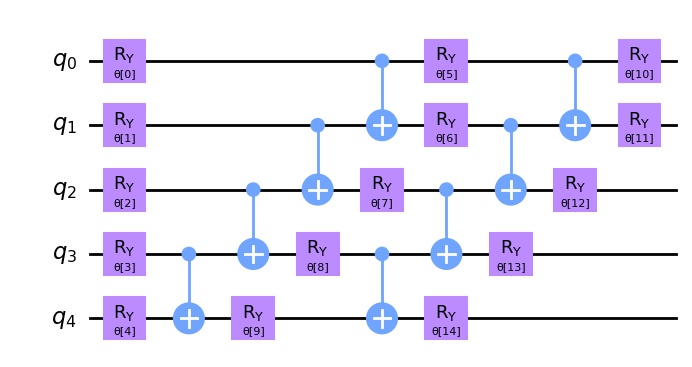

In [46]:
# Make three random circuits using RealAmplitudes

psi1 = RealAmplitudes(num_qubits=5, reps=2) #ejemplo
psi2 = RealAmplitudes(num_qubits=5, reps=3)
psi3 = RealAmplitudes(num_qubits=5, reps=4)

display(psi1.decompose().draw("mpl"))

In [47]:
# Make hamiltonians using SparsePauliOp

H1 = SparsePauliOp.from_list([("IIZXI", 1), ("YIIIY", 3)]) #ejemplo
H2 = SparsePauliOp.from_list([("IXIII", 2)])
H3 = SparsePauliOp.from_list([("IIYII", 3), ("IXIZI",5)])

In [54]:
# Make a list of evenly spaced values for theta between 0 and 1

theta1 = np.linspace(0, 1, 15)  #15 valores
theta2 = np.linspace(0, 1, 20)  #20
theta3 = np.linspace(0, 1, 25)  #25

In [ ]:
# Use the Estimator to calculate each expectation value

with Session(service=service, backend=backend):

    options = Options(simulator={"seed_simulator": 42}, resilience_level=0) # Do not change values in simulator

    estimator = Estimator(options=options)

    # calculate [ <psi1(theta1)|H1|psi1(theta1)>,
    #             <psi2(theta2)|H2|psi2(theta2)>,
    #             <psi3(theta3)|H3|psi3(theta3)> ]
    # Note: Please keep the order
    job = estimator.run(circuits=[psi1,psi2,psi3], parameter_values=[theta1,theta2,theta3], observables=[H1,H2,H3])

    result = job.result()

## Runtime con Ruido

Las primitivas de Runtime tienen incorporadas tecnicas de correccion de errores. Veamos un ejemplo de ejecucion en entorno ruidoso para el Sampler.

Para simular un escenario ruidoso en nuestros simuladores, pasaremos un modelo de ruido a `ibmq_qasm_simulator`. Procederemos creando un modelo de ruido con un `FakeBackend` de `fake_provider` y lo pasaremos con el parámetro opcional `simulator`.

Los backends falsos están diseñados para imitar los comportamientos de los sistemas IBM Quantum utilizando copias del sistema. Las copias del sistema contienen información importante sobre el sistema cuántico, como el mapa de acoplamiento, las compuertas base, las propiedades de los qubits (T1, T2, tasa de error, etc.) que son útiles para realizar una simulación ruidosa del sistema. **[[Fake Providers]](https://qiskit.org/documentation/apidoc/providers_fake_provider.html)**

Para representar nuestras opciones de ejecución, definiremos una instancia de la clase `Options` con parámetros relevantes para definir nuestros valores predeterminados para cada ejecución.

Aquí definiremos dos conjuntos de `Options`. Aquí, `options` con solo el modelo de ruido representará una ejecución normal sin mitigación de errores y `options_with_em` con la opción `resilience_level` establecida en `1` denotará una ejecución con mitigación de errores activa. Después de crearlo, puede agregarlo cuando creas la instancia de tu objeto `Sampler`.

Puedes comprobar cómo crear la instancia `Options` a continuación.

In [57]:
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel

# Import FakeBackend
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include noise_model
options = Options(simulator={
    "noise_model": noise_model,
    "seed_simulator": 42,
}, resilience_level=0)

# Set options to include noise_model and resilience_level
options_with_em = Options(
    simulator={
        "noise_model": noise_model,
        "seed_simulator": 42,
    },
    resilience_level=1
)

En Sampler, se activa correccion de errores cuando estableces el nivel de resiliencia en 1. Ejecutemos el código a continuación y veamos qué tan efectiva es esta técnica.

In [58]:
with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(circuits=[qc]*len(phases), parameter_values=individual_phases)
    param_results = job.result()
    prob_values = [1-dist[0] for dist in param_results.quasi_dists]

    sampler = Sampler(options=options_with_em)
    job = sampler.run(circuits=[qc]*len(phases), parameter_values=individual_phases)
    param_results = job.result()
    prob_values_with_em = [1-dist[0] for dist in param_results.quasi_dists]

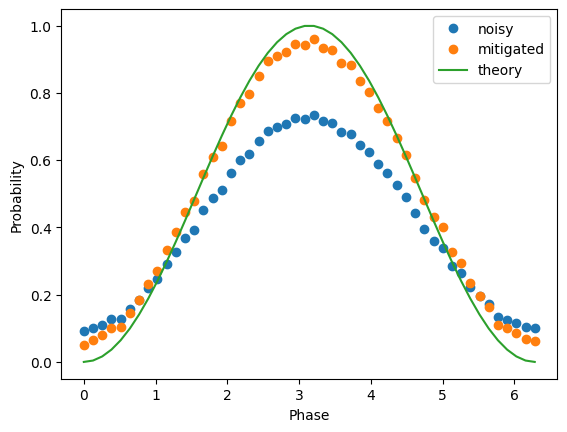

In [59]:
plt.plot(phases, prob_values, 'o', label='noisy')
plt.plot(phases, prob_values_with_em, 'o', label='mitigated')
plt.plot(phases, np.sin(phases/2,)**2, label='theory')
plt.xlabel('Phase')
plt.ylabel('Probability')
plt.legend();